# CLASSIFICAÇÃO MULTICLASSE - SOFTMAX
### Problema: dentificação de atividade humana usando dados de smartphones

- Guilherme Teixeira Semissatto
- RA: 140656
- semissatto@gmail.com

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trainX_df = pd.read_fwf('./Dados/har_smartphone/X_train.txt', header = None)
testX_df = pd.read_fwf('./Dados/har_smartphone/X_test.txt', header = None)
trainY_df = pd.read_csv('./Dados/har_smartphone/y_train.txt', header = None)
testY_df = pd.read_csv('./Dados/har_smartphone/y_test.txt', header = None)

In [3]:
print (testX_df.shape, trainX_df.shape, trainY_df.shape, testY_df.shape)

(2947, 561) (7352, 561) (7352, 1) (2947, 1)


In [4]:
trainX = trainX_df.values
trainY = trainY_df.values
testX = testX_df.values
testY = testY_df.values
print (testX.shape, trainX.shape, trainY.shape, testY.shape)

(2947, 561) (7352, 561) (7352, 1) (2947, 1)


In [5]:
''' subtrai 1 dos valores de saída para ficar de acordo com o enunciado que segue:
# 0 – caminhada; 1 – subindo escadas;
# 2 – descendo escadas; 3 – sentado; 
# 4 – em pé; 5 – deitado '''

for i in range(len(trainY)):
    trainY[i] = trainY[i] - 1

for i in range(len(testY)):
    testY[i] = testY[i] - 1

In [6]:
def one_hot_it(array):
    ''' Recebe uma matriz de probabilidade
    retorna 1 para a maior probabilidade e 0 para o resto, linha a linha '''
    onehot = np.zeros(shape = array.shape)
    #onehot = np.matrix(array.shape[1])
    for i in range(len(array)):
        max_index = array[i].argmax()
        onehot[i][max_index] = 1
    return onehot

[1 0 0 0 0 0]$^T$: caminhando 


[0 1 0 0 0 0]$^T$: subindo escadas


[0 0 1 0 0 0]$^T$: descendo escadas


[0 0 0 1 0 0]$^T$: sentado


[0 0 0 0 1 0]$^T$: parado


[0 0 0 0 0 1]$^T$: deitado

In [7]:
def one_hot_encoder(data):
    ''' Recebe dados categorizados (inteiros) e retorna um vetor one-hot. Exemplo [3]-> [0, 0, 0, 1, 0, 0]'''
    encoded = np.matrix(np.zeros(len(data)*int(max(data)+1))).reshape((len(data), int(max(data)+1)))
    for i in range(len(data)):
        max_index = data[i]
        encoded[i, max_index] = 1
    return encoded

In [8]:
def one_hot_decoder(data):
    ''' Recebe vetor one-hot e converte para categoria. Exemplo [0, 0, 0, 1, 0, 0] -> [3]'''
    decoded = np.zeros(data.shape[0]).reshape(-1,1)
    for i in range(len(data)):
        decoded[i] = np.argmax(data[i])
    return decoded     

In [9]:
def normalize_data(data):
    ''' Converte os valores de um dataset para uma norma <= 1'''
    m, n = data.shape
    for column in range(n):
        max_value = float(max(data[:, column]))
        min_value = float(min(data[:, column]))
        if (abs(min_value) > max_value):
            max_value = abs(min_value)            
        data[:,column] = data[:, column]/max_value
    return data

In [10]:
def softmax(z):
    ''' softmax: recebe net_input(x@w) e gera matriz de probabilidades conforme cada classe '''
    numerator = np.exp(z.T)
    denominator = np.sum(np.exp(z), axis = 1)
    return (np.transpose(numerator/denominator.T))

### Normalização dos dados
- Uma vez que os dados passarão por uma função de ativação do tipo exponencial, os dados foram normalizados de forma que sua norma nunca ultrapasse 1

In [11]:
testX_normalized = normalize_data(testX)
trainX_normalized = normalize_data(trainX)

In [13]:
def calcGradLoss(w,x,y,m):
    ''' Calcula o gradiente e a função de custo do tipo (Zero One Loss) para a instância de treinamento '''
    y_mat = one_hot_encoder(y) 
    scores = np.dot(x,w) 
    prob = softmax(scores) 
    ŷ_ = one_hot_it(prob)
    loss = zero_one_loss(y_mat, ŷ_)
    grad = (-1 / m) * np.dot(x.T,(y_mat - prob)) 
    return grad, loss

In [14]:
def zero_one_loss(y, ŷ):
    ''' Calcula quão diferente está a estimativa de classe da classe real
        a partir da norma do vetor diferença (esperado - estimado)'''
    diff = (y - ŷ)
    norma = np.dot(diff.T, diff)/2
    soma_linha = np.sum(abs(norma), axis = 1)
    total_error = np.sum(soma_linha)
    loss = total_error/len(y)
    return loss

### Loop de treinamento
- O treinamento é baseado em esforço computacional com base no gradiente descendente para o softmax (entropia cruzada)
- Como métrica de desempenho, utilizou-se Zero One Loss comentado acima que calcula quão diferente está a estimativa de classe da classe real a partir da norma do vetor diferença (esperado - estimado)
- O algoritmo itera atualizando seus pesos com base num passo de aprendizado (learningRate) * gradiente, até se chegar em um erro Zero One Loss menor que 0.1
- O cálculo do gradiente foi podenrado pelo número de amostras do dataset e para a solução convergir utilizou-se um passo de aprendizado (learningRate) de 0.05, valores superior a isso geravam instabilidades na solução (analisados empiricamente)

In [15]:
x = trainX_normalized
x = np.insert(x, 0, 1, 1) # adiciona coluna de 1's (bias)
y = trainY
n_features = x.shape[1]
n_classes = len(np.unique(y))
n_samples = x.shape[0]

# inicia matriz de pesos com dim = (#features + 1, #classes)
w = np.random.rand(n_features*n_classes).reshape(n_features, n_classes) 
learningRate = 0.05
losses = []
loss = 9e9
tolerance = 0.1

#for i in range(0,iterations):
while (loss > tolerance):
    grad, loss = calcGradLoss(w,x,y,n_samples)
    losses.append(loss)
    w = w - (learningRate * grad)

### Progressão do One Zero Loss
- Conforme o modelo aprende (itera) com base no gradiente, os pesos são otimizados e desta forma a taxa de erro One Zero Loss tende a diminuir tendo em vista que o modelo começa acertar mais
- A figura abaixo mostra o progresso da taxa One Zero loss para cada época ("epochs") do treinamento

min loss: 0.09983677910772579


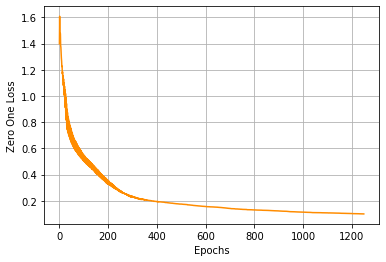

In [16]:
print("min loss:", min(losses))
plt.plot(losses, color = "darkorange")
plt.xlabel("Epochs")
plt.ylabel("Zero One Loss")
plt.grid(True)

### Avaliando o modelo ótimo

In [17]:
x = testX_normalized
x = np.insert(x, 0, 1, 1) # adiciona coluna de 1's (bias)
y = testY
ŷ = one_hot_it(softmax(x@w))
ŷ = one_hot_decoder(ŷ)

def calc_error(ŷ, y):
    acerto = 0
    erro = 0
    for i in range(len(ŷ)):
        if int(ŷ[i]) == int(y[i]):
            acerto += 1
        else:
            erro += 1
    print("acertos:\t", acerto, "\nerros:\t\t", erro, "\nerro(%):\t", 100*erro/(acerto+erro))

calc_error(ŷ,y)

acertos:	 2712 
erros:		 235 
erro(%):	 7.974211062097048


### Matriz de confusão
- A matriz de confusão explora as métricas de um classificador. Em sua diagonal principal temos os acertos (Verdadeiro Positivo e Verdadeiro Negativo). Enquanto na diagonal anti-principal temos os erros do modelo (Falso positivo e Falso Negativo)

In [18]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
y_true = y
y_pred = ŷ
multilabel_confusion_matrix(y_true, y_pred, labels = np.unique(y))
confusion_matrix(y_true, y_pred, labels = np.unique(y))

array([[481,   4,  11,   0,   0,   0],
       [ 18, 424,  29,   0,   0,   0],
       [ 16,  29, 375,   0,   0,   0],
       [  0,   4,   0, 393,  91,   3],
       [  0,   1,   0,  29, 502,   0],
       [  0,   0,   0,   0,   0, 537]])